In [1]:
import json
from networkx.readwrite import json_graph

# Try reading the data back in -- writing this function for Jonathan
def read_data_for_jonathan():
    with open('data/possessions_for_jonathan.json', 'r') as f:
        possessions_for_jonathan = json.load(f)
    
    for possession in possessions_for_jonathan:
        possession['attacking_graph'] = json_graph.node_link_graph(possession['attacking_graph'])
        possession['defensive_graphs'] = [json_graph.node_link_graph(G_defense) for G_defense in possession['defensive_graphs']]

    return possessions_for_jonathan

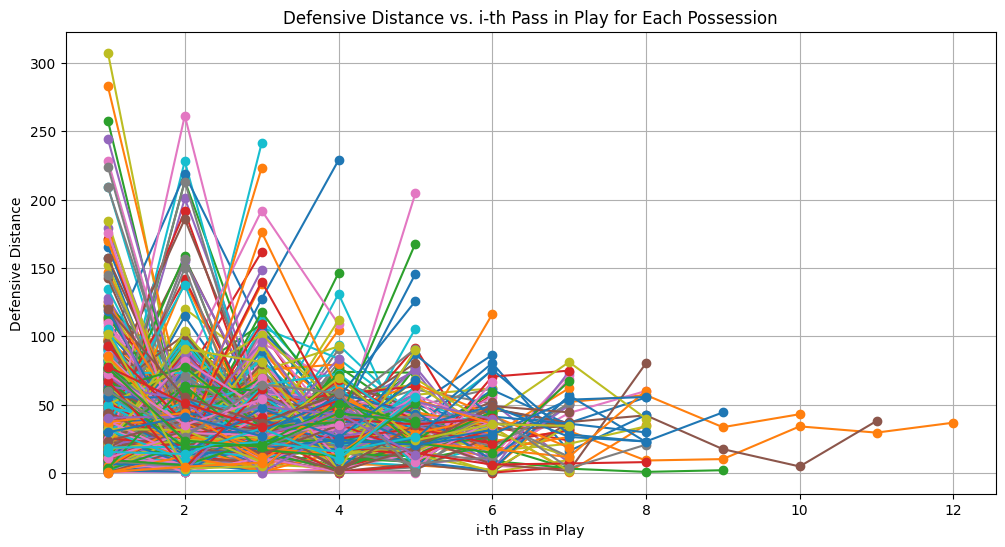

In [3]:
from matplotlib import pyplot as plt

def create_defensive_distance_graph():
    possessions = read_data_for_jonathan()

    plt.figure(figsize=(12, 6))
    for i, possession in enumerate(possessions):
        if 'CombinedPasses' in possession:
            distances = [pass_['distance'] for pass_ in possession['CombinedPasses']]
            plt.plot(range(1, len(distances) + 1), distances, marker='o', label=f'Possession {i+1}')

    plt.xlabel('i-th Pass in Play')
    plt.ylabel('Defensive Distance')
    plt.title('Defensive Distance vs. i-th Pass in Play for Each Possession')
    # plt.legend()
    plt.grid(True)
    plt.show()
create_defensive_distance_graph()

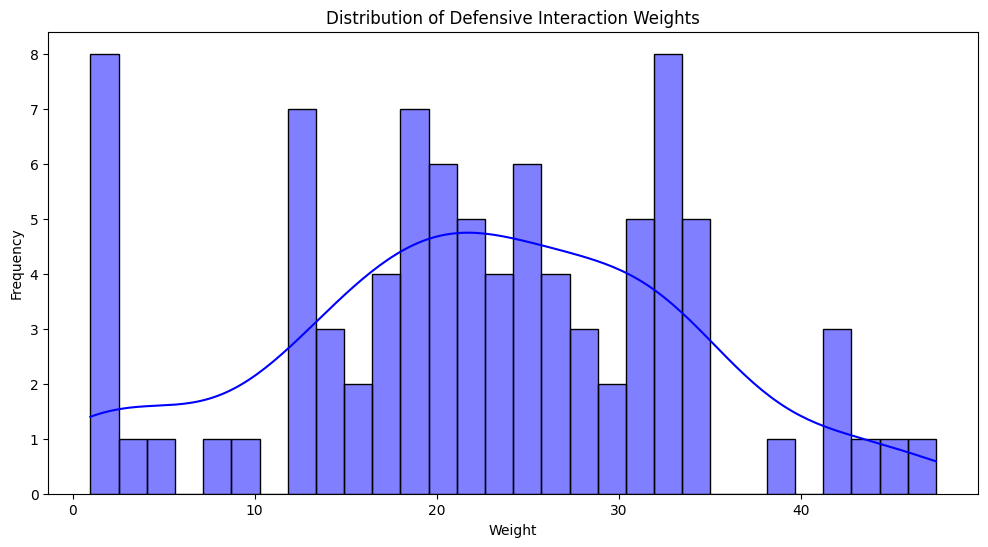

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_weighted_heat_map():
    possessions = read_data_for_jonathan()

    # Aggregating weights from all defensive graphs in the first possession
    all_weights = []

    for defensive_graph in possessions[0]['defensive_graphs']:
        # Extracting weights from the edges of each graph
        weights = nx.get_edge_attributes(defensive_graph, 'weight').values()
        all_weights.extend(weights)
    
    # Here we use a histogram to represent the frequency of different weights
    plt.figure(figsize=(12, 6))
    sns.histplot(all_weights, bins=30, kde=True, color="blue")
    plt.title('Distribution of Defensive Interaction Weights')
    plt.xlabel('Weight')
    plt.ylabel('Frequency')
    plt.show()

plot_weighted_heat_map()


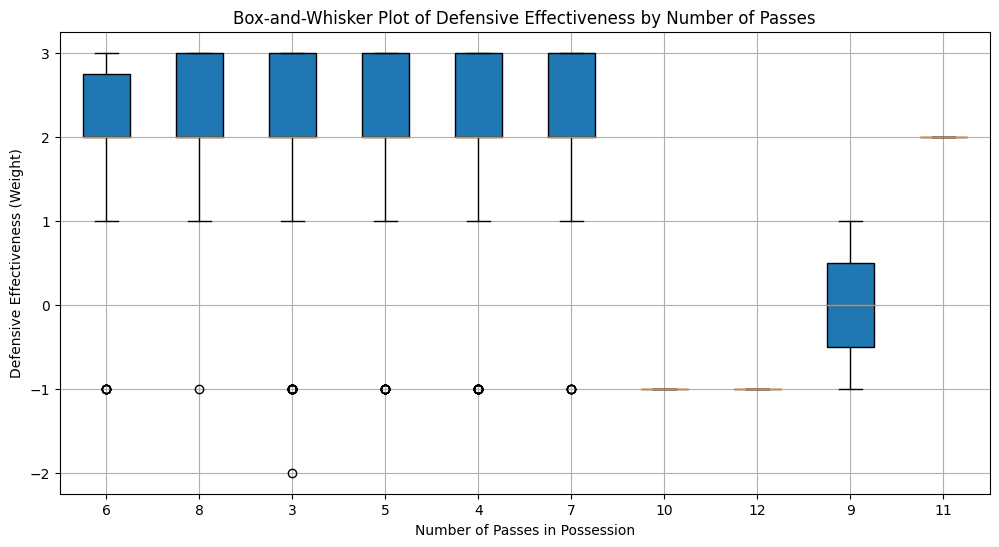

In [17]:
import matplotlib.pyplot as plt

def plot_box_and_whisker_passes_vs_effectiveness():
    possessions = read_data_for_jonathan()

    plt.figure(figsize=(12, 6))

    # Grouping possessions by the number of passes
    passes_to_weights = {}
    for possession in possessions:
        num_passes = len(possession['CombinedPasses']) if 'CombinedPasses' in possession else 0
        if num_passes not in passes_to_weights:
            passes_to_weights[num_passes] = []
        passes_to_weights[num_passes].append(possession["Weight"])

    # Preparing data for the box plot
    labels, data = zip(*passes_to_weights.items())

    plt.boxplot(data, labels=labels, patch_artist=True)
    plt.xlabel('Number of Passes in Possession')
    plt.ylabel('Defensive Effectiveness (Weight)')
    plt.title('Box-and-Whisker Plot of Defensive Effectiveness by Number of Passes')
    plt.grid(True)
    plt.show()

plot_box_and_whisker_passes_vs_effectiveness()

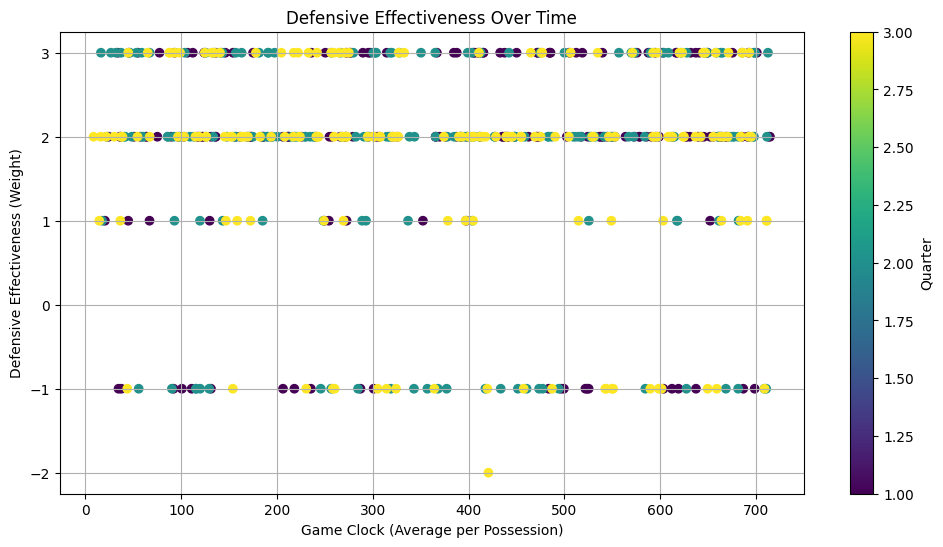

In [18]:
import matplotlib.pyplot as plt

def plot_defensive_effectiveness_over_time():
    possessions = read_data_for_jonathan()

    plt.figure(figsize=(12, 6))

    # Data preparation
    time_effectiveness = []
    for possession in possessions:
        if 'CombinedPasses' in possession and possession['CombinedPasses']:
            avg_game_clock = sum([p['GameClock'] for p in possession['CombinedPasses']]) / len(possession['CombinedPasses'])
            quarter = possession['CombinedPasses'][0]['Quarter']
            weight = possession['Weight']
            time_effectiveness.append((quarter, avg_game_clock, weight))

    # Sorting data by quarter and game clock
    time_effectiveness.sort(key=lambda x: (x[0], x[1]))

    # Plotting
    quarters, game_clocks, weights = zip(*time_effectiveness)
    plt.scatter(game_clocks, weights, c=quarters, cmap='viridis')
    plt.colorbar(label='Quarter')
    plt.xlabel('Game Clock (Average per Possession)')
    plt.ylabel('Defensive Effectiveness (Weight)')
    plt.title('Defensive Effectiveness Over Time')
    plt.grid(True)
    plt.show()

plot_defensive_effectiveness_over_time()


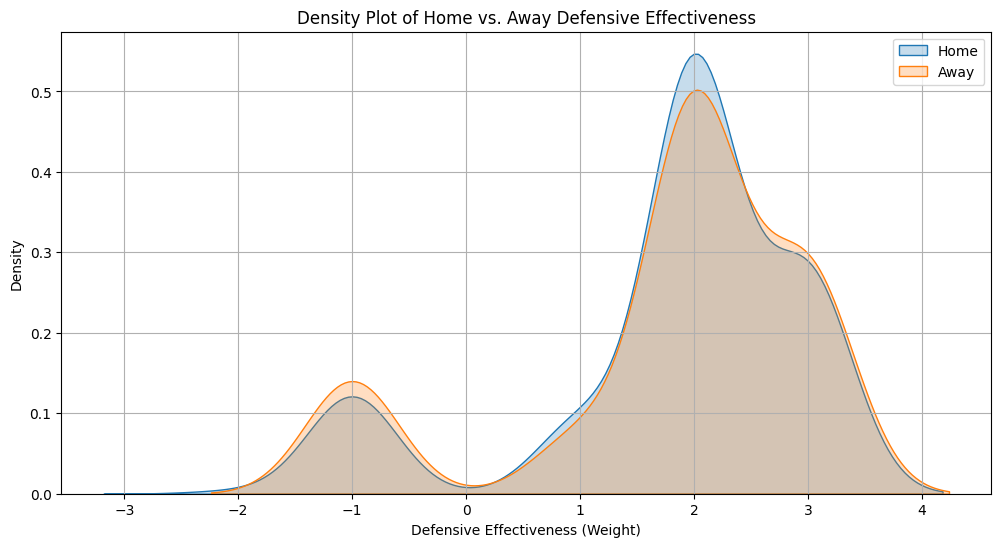

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

def determine_defending_team(passes, home_players, guest_players):
    # Assuming the first pass indicates who has the ball
    if passes[0]['pass_from'] in home_players:
        return 'away'
    else:
        return 'home'

def perform_density_analysis():
    possessions = read_data_for_jonathan()

    home_defense_weights = []
    away_defense_weights = []

    for possession in possessions:
        if 'Passes' in possession and possession['Passes']:
            defending_team = determine_defending_team(possession['Passes'],
                                                      possession['Passes'][0]['snapshots'][0]['HomePlayers'],
                                                      possession['Passes'][0]['snapshots'][0]['GuestPlayers'])
            if defending_team == 'home':
                home_defense_weights.append(possession['Weight'])
            else:
                away_defense_weights.append(possession['Weight'])

    # Density Plot
    plt.figure(figsize=(12, 6))
    sns.kdeplot(home_defense_weights, label='Home', fill=True)
    sns.kdeplot(away_defense_weights, label='Away', fill=True)
    plt.xlabel('Defensive Effectiveness (Weight)')
    plt.title('Density Plot of Home vs. Away Defensive Effectiveness')
    plt.legend()
    plt.grid(True)
    plt.show()

perform_density_analysis()

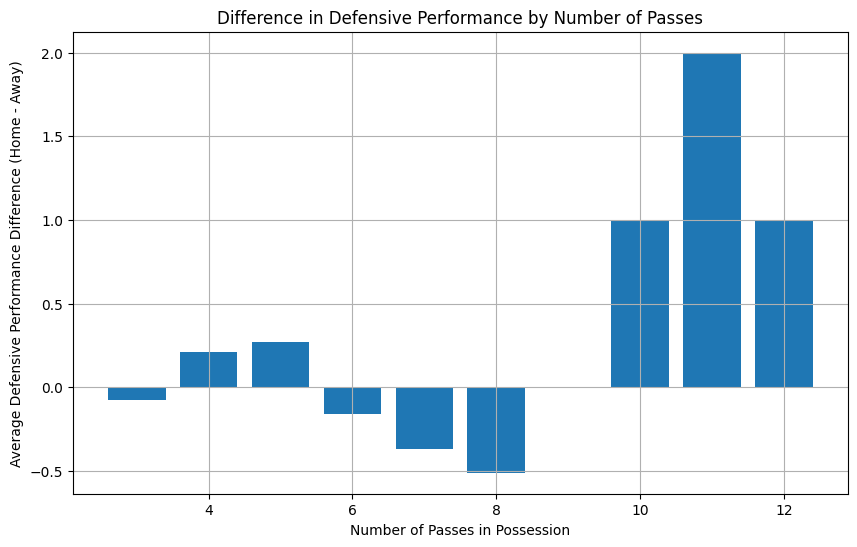

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_and_visualize_performance_difference():
    possessions = read_data_for_jonathan()

    home_defense_by_passes = {}
    away_defense_by_passes = {}

    for possession in possessions:
        num_passes = len(possession['CombinedPasses']) if 'CombinedPasses' in possession else 0
        weight = possession['Weight']
        defending_team = determine_defending_team(possession['Passes'],
                                                  possession['Passes'][0]['snapshots'][0]['HomePlayers'],
                                                  possession['Passes'][0]['snapshots'][0]['GuestPlayers'])

        if defending_team == 'home':
            if num_passes not in home_defense_by_passes:
                home_defense_by_passes[num_passes] = []
            home_defense_by_passes[num_passes].append(weight)
        else:
            if num_passes not in away_defense_by_passes:
                away_defense_by_passes[num_passes] = []
            away_defense_by_passes[num_passes].append(weight)

    # Calculating average performance for each number of passes
    performance_diff = {}
    for num_passes in set(home_defense_by_passes.keys()).union(away_defense_by_passes.keys()):
        home_avg = np.mean(home_defense_by_passes.get(num_passes, [0]))
        away_avg = np.mean(away_defense_by_passes.get(num_passes, [0]))
        performance_diff[num_passes] = home_avg - away_avg

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.bar(performance_diff.keys(), performance_diff.values())
    plt.xlabel('Number of Passes in Possession')
    plt.ylabel('Average Defensive Performance Difference (Home - Away)')
    plt.title('Difference in Defensive Performance by Number of Passes')
    plt.grid(True)
    plt.show()

calculate_and_visualize_performance_difference()

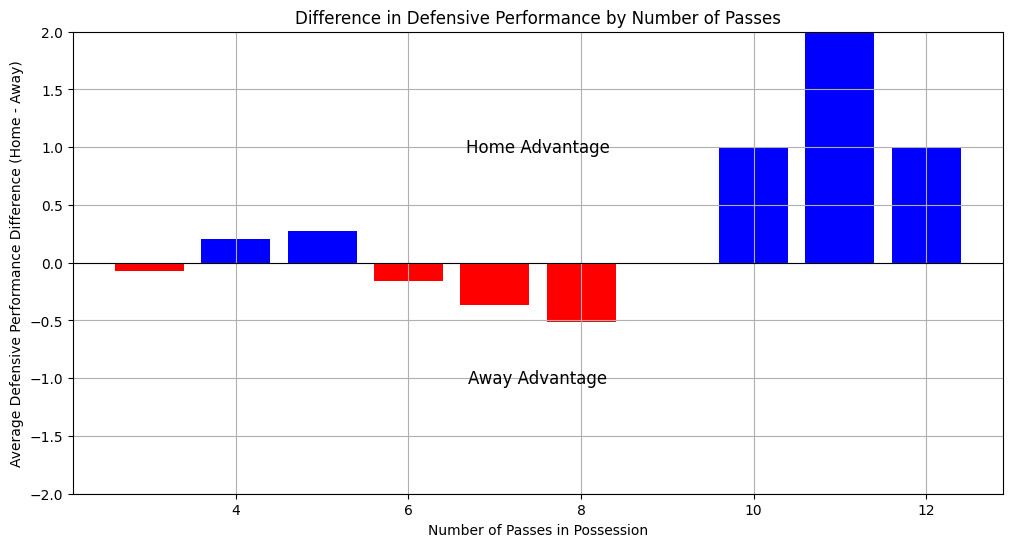

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_and_visualize_performance_difference():
    possessions = read_data_for_jonathan()

    home_defense_by_passes = {}
    away_defense_by_passes = {}

    for possession in possessions:
        num_passes = len(possession['CombinedPasses']) if 'CombinedPasses' in possession else 0
        weight = possession['Weight']
        defending_team = determine_defending_team(possession['Passes'],
                                                  possession['Passes'][0]['snapshots'][0]['HomePlayers'],
                                                  possession['Passes'][0]['snapshots'][0]['GuestPlayers'])

        if defending_team == 'home':
            if num_passes not in home_defense_by_passes:
                home_defense_by_passes[num_passes] = []
            home_defense_by_passes[num_passes].append(weight)
        else:
            if num_passes not in away_defense_by_passes:
                away_defense_by_passes[num_passes] = []
            away_defense_by_passes[num_passes].append(weight)

    # Calculating average performance for each number of passes
    performance_diff = {}
    for num_passes in set(home_defense_by_passes.keys()).union(away_defense_by_passes.keys()):
        home_avg = np.mean(home_defense_by_passes.get(num_passes, [0]))
        away_avg = np.mean(away_defense_by_passes.get(num_passes, [0]))
        performance_diff[num_passes] = home_avg - away_avg

    # Visualization
    plt.figure(figsize=(12, 6))
    bar_colors = ['blue' if value > 0 else 'red' for value in performance_diff.values()]

    bars = plt.bar(performance_diff.keys(), performance_diff.values(), color=bar_colors)
    plt.axhline(0, color='black', linewidth=0.8)  # Add a line at y=0

    # Adding labels to indicate home or away advantage
    plt.text(0.5, 0.75, 'Home Advantage', fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
    plt.text(0.5, 0.25, 'Away Advantage', fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)

    plt.xlabel('Number of Passes in Possession')
    plt.ylabel('Average Defensive Performance Difference (Home - Away)')
    plt.title('Difference in Defensive Performance by Number of Passes')

    # Set y-axis limits to be symmetrical
    y_abs_max = np.max(np.abs(list(performance_diff.values())))
    plt.ylim([-y_abs_max, y_abs_max])

    plt.grid(True)
    plt.show()

calculate_and_visualize_performance_difference()

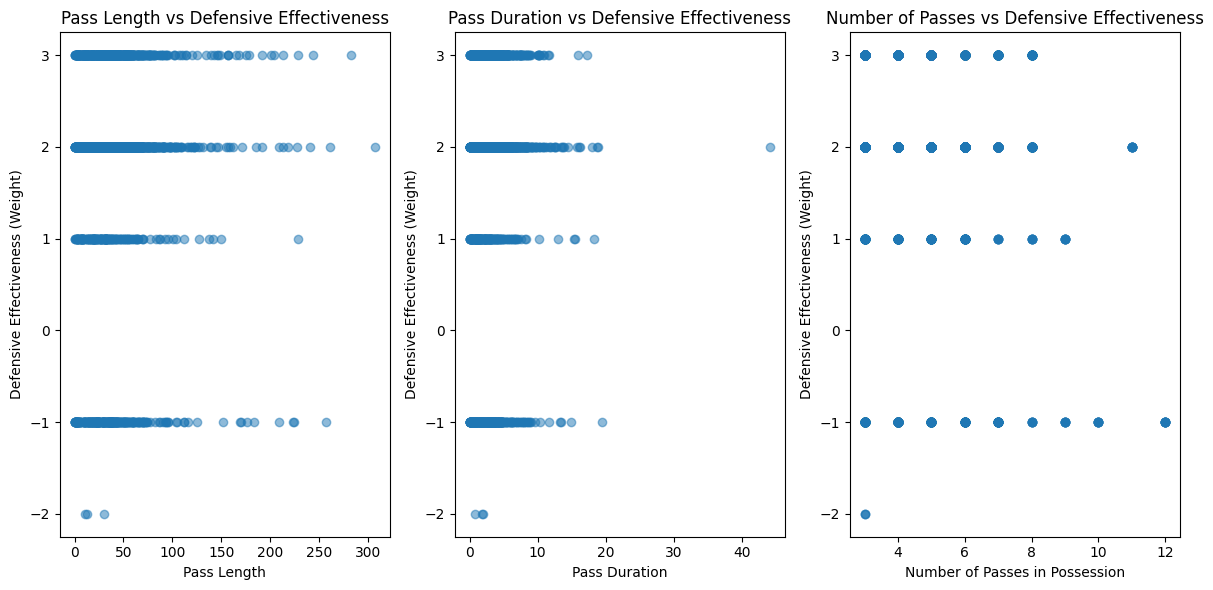

In [40]:
import matplotlib.pyplot as plt

def perform_passing_pattern_analysis():
    possessions = read_data_for_jonathan()

    pass_lengths = []
    pass_durations = []
    num_passes = []
    defensive_weights = []

    for possession in possessions:
        if 'CombinedPasses' in possession and possession['CombinedPasses']:
            lengths = [pass_['distance'] for pass_ in possession['CombinedPasses']]
            durations = [pass_['pass_duration'] for pass_ in possession['CombinedPasses']]
            weight = possession['Weight']
            
            pass_lengths.extend(lengths)
            pass_durations.extend(durations)
            num_passes.extend([len(possession['CombinedPasses'])] * len(lengths))
            defensive_weights.extend([weight] * len(lengths))

    # Visualization
    plt.figure(figsize=(12, 6))

    # Pass Length vs Defensive Effectiveness
    plt.subplot(1, 3, 1)
    plt.scatter(pass_lengths, defensive_weights, alpha=0.5)
    plt.xlabel('Pass Length')
    plt.ylabel('Defensive Effectiveness (Weight)')
    plt.title('Pass Length vs Defensive Effectiveness')

    # Pass Duration vs Defensive Effectiveness
    plt.subplot(1, 3, 2)
    plt.scatter(pass_durations, defensive_weights, alpha=0.5)
    plt.xlabel('Pass Duration')
    plt.ylabel('Defensive Effectiveness (Weight)')
    plt.title('Pass Duration vs Defensive Effectiveness')

    # Number of Passes vs Defensive Effectiveness
    plt.subplot(1, 3, 3)
    plt.scatter(num_passes, defensive_weights, alpha=0.5)
    plt.xlabel('Number of Passes in Possession')
    plt.ylabel('Defensive Effectiveness (Weight)')
    plt.title('Number of Passes vs Defensive Effectiveness')

    plt.tight_layout()
    plt.show()

perform_passing_pattern_analysis()